<a href="https://colab.research.google.com/github/golden77777/Deep-Learning-Exercise/blob/master/nanacomi_topic_denoising_polar_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
import statistics
import seaborn as sns
%matplotlib inline
import MeCab

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import pairwise_distances
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
from surprise import (
    NormalPredictor, BaselineOnly, KNNBasic, KNNWithMeans, KNNWithZScore,
    KNNBaseline, SVD, SVDpp, NMF, SlopeOne, CoClustering
)


# サービスアカウントのキーを通す（API接続のため）
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content/gaudiy-develop-tokyo-ed2268d90d1a.json'

PARAMS = {
    'target_tenant': 'nananiji-qicpv',
    'activity_measure': 'like', #pv, like, reply
    'activity_measure_nunc': 'pv', #pv, like, reply
    'excludes_official_contents': True,
    'n_contents_to_recommend': 10,
    'n_related_users': 10,
}

In [3]:
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option("display.max_colwidth", None)


# ナナコミの各投稿のいいね数と文字の数の関係を再計算する(公式なし，ノイズなし)

In [4]:
df_topic_nanacomi_new = pd.read_csv("nanacomi_topic_except_official_denoising_new.csv")

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
!apt-get -q -y install sudo file mecab libmecab-dev mecab-ipadic-utf8 git curl python-mecab > /dev/null
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git > /dev/null
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n > /dev/null 2>&1
!pip install mecab-python3 > /dev/null

E: Unable to locate package python-mecab
Cloning into 'mecab-ipadic-neologd'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 75 (delta 5), reused 54 (delta 0), pack-reused 0
Unpacking objects: 100% (75/75), 58.09 MiB | 14.35 MiB/s, done.


In [ ]:
df_topic_nanacomi_new.head(3)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1,topic_id,tenant_id,user_id,community_event_id,group_ids,quiz_id,created_at_jst,updated_at_jst,title,description,images,type,message_count,favorite_senders,likes_total_amount,is_pickup,is_edited,is_deleted,is_deleted_by_owner,execute_deletion_user_id,community_id,community_icon,community_domain,community_is_published,community_top_image,community_name,community_color,community_logo_image,community_member_count,community_summary,community_topics,user_created_at_jst,user_leaved_at_jst,user_display_name,user_photo_url,user_profile,user_signup_step,user_is_feature_flag_enabled,user_is_force_log_rocket_target,sentence_length,sentence_length_log,0,like_nimber,like_number,word_length_range,word_length_range_new,0.1,pv_number,0.1.1,denoising_description_new,denoising_description_feeling
0,0,8,8,8,2820,2820,2825,HmmxFVDfXJsbwGxvAq3j,nananiji-qicpv,X7JEZwmRTzL0EhuxXz1lEvz98Ca2,NaN,['3dEPwlMtjlx4dCkyiSKx'],NaN,2020-06-24 18:02:53.000,2020-06-24 18:02:53.000,よろしくおねがいします！,戸田ジュン推しです,['https://storage.googleapis.com/nananiji-qicpv/topicImages/159298937263976423C09-ABA5-47A2-941E-B970A5535354.jpeg'],default,0,['27PTvlg5mMa7zeoxIYtkJlO18Jo2' 'glEiRZrKJVf9EebiqUxWyB1kyeA2'\n 'moXvjf75OwR3AdhbFjbvysFfw5O2' 'o0z0q3K3X0VQwMtlvU2WF2KbC1m2'\n 'XxQgQGwKUVhLXQSmsB8uHCLgiFI2'],7,False,False,False,False,NaN,faAGHO70RFeCjbGxJWj1,https://storage.googleapis.com/nananiji-qicpv/community/PWA%E3%82%A2%E3%82%A4%E3%82%B3%E3%83%B3.png,nana-comi.com,False,https://storage.googleapis.com/nananiji-qicpv/community/home_image.png,ナナコミ,#57B1FF,https://storage.googleapis.com/nananiji-qicpv/community/community_logo_nanacomi_original.png,18183,"[{'faqTitle': '初心者向け！コミュニティの楽しみ方ガイド', 'title': '22/7 公式コミュニティ 「ナナコミ」', 'faqLink': 'https://nana-comi.com/topic/faAGHO70RFeCjbGxJWj1/jQEZM8XRMTHTAyHn8GJ2', 'officialPhrase': '公式ファンサイト', '__key__': {'namespace': '', 'app': '', 'path': '', 'kind': None, 'name': None, 'id': None}}]","[{'community_topic_id': None, 'community_topic_created_at_jst': None, 'community_topic_label': None, 'community_topic_description': None, 'community_topic_image_url': None, 'community_topic_hashtags': array([], dtype=object), 'community_topic_index': None, 'community_topic_post_count': None, 'community_topic_is_deleted': None}]",2020-06-24 18:01:20.000,1970-01-01 09:00:00.000,ぼた,https://pbs.twimg.com/profile_images/1271995527521943553/DPa8yIZl.jpg,NaN,GROUP_FOLLOWED,False,False,9,1.000000,20683,7,7,50.0,100.0,7977,0,20723,戸田ジュン推しです,"トダ,ジュン,押す,です"
1,1,9,9,9,2821,2821,2826,hDHBgCwmF2T0a5AqGr7s,nananiji-qicpv,jnTfc8zrMJh6j50Oa7DcyAeXa9G3,NaN,['3dEPwlMtjlx4dCkyiSKx'],NaN,2020-06-24 18:04:23.000,2023-04-12 11:28:44.000,挨拶,よろしゅうお頼み申しあげますm(_ _)m,['https://storage.googleapis.com/nananiji-qicpv/topicImages/1592989462999u12tsz.jpg'],default,1,['EfqIyRPisDgSkinGLNOYSxEVQbA3'],1,False,False,False,False,NaN,faAGHO70RFeCjbGxJWj1,https://storage.googleapis.com/nananiji-qicpv/community/PWA%E3%82%A2%E3%82%A4%E3%82%B3%E3%83%B3.png,nana-comi.com,False,https://storage.googleapis.com/nananiji-qicpv/community/home_image.png,ナナコミ,#57B1FF,https://storage.googleapis.com/nananiji-qicpv/community/community_logo_nanacomi_original.png,18183,"[{'faqTitle': '初心者向け！コミュニティの楽しみ方ガイド', 'title': '22/7 公式コミュニティ 「ナナコミ」', 'faqLink': 'https://nana-comi.com/topic/faAGHO70RFeCjbGxJWj1/jQEZM8XRMTHTAyHn8GJ2', 'officialPhrase': '公式ファンサイト', '__key__': {'namespace': '', 'app': '', 'path': '', 'kind': None, 'name': None, 'id': None}}]","[{'community_topic_id': None, 'community_topic_created_at_jst': None, 'community_topic_label': None, 'community_topic_description': None, 'community_topic_image_url': None, 'community_topic_hashtags': array([], dtype=object), 'community_topic_index': None, 'community_topic_post_count': None, 'community_topic_is_deleted': None}]",2020-06-24 18:01:10.000,1970-01-01 09:00:00.000,🔥ワタルアイ🌲固ツイ🙏,https://storage.googleapis.com/gaudiy-production-tokyo.appspot.com/i

In [ ]:
!ln -s /etc/mecabrc /usr/local/etc/mecabrc

In [ ]:
!echo `mecab-config --dicdir`"/mecab-ipadic-neologd"

/bin/bash: mecab-config: command not found
/mecab-ipadic-neologd


# 極性辞書として，「日本語評価極性辞書（名詞編）」を用いる

https://www.cl.ecei.tohoku.ac.jp/Open_Resources-Japanese_Sentiment_Polarity_Dictionary.html

In [5]:
mecab = MeCab.Tagger('mecab-ipadic-neologd')

In [9]:
pndic_1 = pd.read_csv('pn.csv.m3.120408.trim', names=['word_pn_oth'])
# print(pndic_1)
pndic_2 = pndic_1['word_pn_oth'].str.split('\t', expand=True)
# print(pndic_2)
senti_score = pd.Series(pndic_2[1])
senti_score.value_counts()

n       4958
e       4954
p       3352
?p?n      35
?e         4
a          4
o          3
?p         2
?p?e       1
　         1
Name: 1, dtype: int64

In [11]:
pndic_3 = pndic_2[(pndic_2[1] == 'p') | (pndic_2[1] == 'e') | (pndic_2[1] == 'n')]
# print(pndic_3)

In [13]:
# 不要カラムの削除
pndic_4 = pndic_3.drop(pndic_3.columns[2], axis=1)

pndic_4[1] = pndic_4[1].replace({'p':1, 'e':0, 'n':-1})
# print(pndic_4)

In [14]:
keys = pndic_4[0].tolist()
values = pndic_4[1].tolist()
dic = dict(zip(keys, values))

In [16]:
df_descrip = df_topic_nanacomi_new["denoising_description_new"]

In [15]:
df_descrip = df_topic_nanacomi_new["denoising_description_new"]

In [30]:
#mean_list_main = []
for i in range(len(df_descrip)):
  text = df_descrip[i]
  try:
    lines = text.split("。")
  except AttributeError:
    lines = text
  # 形態素解析に基づいて単語を抽出
  # まずは，極性分析のために形態素解析を行う
  word_list = []
  try:
    for l in lines:
        temp = []
        for v in mecab.parse(l).splitlines():
            if len(v.split()) >= 4:
                if v.split()[4][:2] in ['名詞','形容詞','動詞','副詞']:
                    temp.append(v.split()[3])
        word_list.append(temp)

    # 空の要素を削除
    word_list = [x for x in word_list if x != []]

    #print(word_list)
    result = []
    # 文単位の処理
    for sentence in word_list:
        temp = []
        # 語単位の処理
        for word in sentence:
            word_score = []
            score = dic.get(word)
            word_score = (word, score)
            temp.append(word_score)
        result.append(temp)
    # 文毎にデータフレーム化して表示
    # for i in range(len(result)):
    #     print(lines[i], '\n', pd.DataFrame(result[i], columns=["word", "score"]), '\n')
    # 文単位の平均値を計算
    mean_list = []
    for i in result:
        temp = []
        for j in i:
            if not j[1] == None:
                temp.append(float(j[1]))
        mean = (sum(temp) / (len(temp) + 0.00001))
        mean_list_main.append(mean)
  except TypeError:
    mean_list = []
    mean = 0
    mean_list_main.append(mean)
  # データフレーム化して表示
#print(pd.DataFrame(mean_list_main, columns=["mean"]))

In [19]:
a = pd.DataFrame(mean_list_main, columns=["mean"])

In [20]:
df_topic_nanacomi_new["polar_new"] = a

In [21]:
df_topic_nanacomi_new.head(10)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1,topic_id,tenant_id,user_id,community_event_id,group_ids,quiz_id,created_at_jst,updated_at_jst,title,description,images,type,message_count,favorite_senders,likes_total_amount,is_pickup,is_edited,is_deleted,is_deleted_by_owner,execute_deletion_user_id,community_id,community_icon,community_domain,community_is_published,community_top_image,community_name,community_color,community_logo_image,community_member_count,community_summary,community_topics,user_created_at_jst,user_leaved_at_jst,user_display_name,user_photo_url,user_profile,user_signup_step,user_is_feature_flag_enabled,user_is_force_log_rocket_target,sentence_length,sentence_length_log,0,like_nimber,like_number,word_length_range,word_length_range_new,0.1,pv_number,0.1.1,denoising_description_new,polar_new
0,0,8,8,8,2820,2820,2825,HmmxFVDfXJsbwGxvAq3j,nananiji-qicpv,X7JEZwmRTzL0EhuxXz1lEvz98Ca2,NaN,['3dEPwlMtjlx4dCkyiSKx'],NaN,2020-06-24 18:02:53.000,2020-06-24 18:02:53.000,よろしくおねがいします！,戸田ジュン推しです,['https://storage.googleapis.com/nananiji-qicpv/topicImages/159298937263976423C09-ABA5-47A2-941E-B970A5535354.jpeg'],default,0,['27PTvlg5mMa7zeoxIYtkJlO18Jo2' 'glEiRZrKJVf9EebiqUxWyB1kyeA2'\n 'moXvjf75OwR3AdhbFjbvysFfw5O2' 'o0z0q3K3X0VQwMtlvU2WF2KbC1m2'\n 'XxQgQGwKUVhLXQSmsB8uHCLgiFI2'],7,False,False,False,False,NaN,faAGHO70RFeCjbGxJWj1,https://storage.googleapis.com/nananiji-qicpv/community/PWA%E3%82%A2%E3%82%A4%E3%82%B3%E3%83%B3.png,nana-comi.com,False,https://storage.googleapis.com/nananiji-qicpv/community/home_image.png,ナナコミ,#57B1FF,https://storage.googleapis.com/nananiji-qicpv/community/community_logo_nanacomi_original.png,18183,"[{'faqTitle': '初心者向け！コミュニティの楽しみ方ガイド', 'title': '22/7 公式コミュニティ 「ナナコミ」', 'faqLink': 'https://nana-comi.com/topic/faAGHO70RFeCjbGxJWj1/jQEZM8XRMTHTAyHn8GJ2', 'officialPhrase': '公式ファンサイト', '__key__': {'namespace': '', 'app': '', 'path': '', 'kind': None, 'name': None, 'id': None}}]","[{'community_topic_id': None, 'community_topic_created_at_jst': None, 'community_topic_label': None, 'community_topic_description': None, 'community_topic_image_url': None, 'community_topic_hashtags': array([], dtype=object), 'community_topic_index': None, 'community_topic_post_count': None, 'community_topic_is_deleted': None}]",2020-06-24 18:01:20.000,1970-01-01 09:00:00.000,ぼた,https://pbs.twimg.com/profile_images/1271995527521943553/DPa8yIZl.jpg,NaN,GROUP_FOLLOWED,False,False,9,1.000000,20683,7,7,50.0,100.0,7977,0,20723,戸田ジュン推しです,0.000000
1,1,9,9,9,2821,2821,2826,hDHBgCwmF2T0a5AqGr7s,nananiji-qicpv,jnTfc8zrMJh6j50Oa7DcyAeXa9G3,NaN,['3dEPwlMtjlx4dCkyiSKx'],NaN,2020-06-24 18:04:23.000,2023-04-12 11:28:44.000,挨拶,よろしゅうお頼み申しあげますm(_ _)m,['https://storage.googleapis.com/nananiji-qicpv/topicImages/1592989462999u12tsz.jpg'],default,1,['EfqIyRPisDgSkinGLNOYSxEVQbA3'],1,False,False,False,False,NaN,faAGHO70RFeCjbGxJWj1,https://storage.googleapis.com/nananiji-qicpv/community/PWA%E3%82%A2%E3%82%A4%E3%82%B3%E3%83%B3.png,nana-comi.com,False,https://storage.googleapis.com/nananiji-qicpv/community/home_image.png,ナナコミ,#57B1FF,https://storage.googleapis.com/nananiji-qicpv/community/community_logo_nanacomi_original.png,18183,"[{'faqTitle': '初心者向け！コミュニティの楽しみ方ガイド', 'title': '22/7 公式コミュニティ 「ナナコミ」', 'faqLink': 'https://nana-comi.com/topic/faAGHO70RFeCjbGxJWj1/jQEZM8XRMTHTAyHn8GJ2', 'officialPhrase': '公式ファンサイト', '__key__': {'namespace': '', 'app': '', 'path': '', 'kind': None, 'name': None, 'id': None}}]","[{'community_topic_id': None, 'community_topic_created_at_jst': None, 'community_topic_label': None, 'community_topic_description': None, 'community_topic_image_url': None, 'community_topic_hashtags': array([], dtype=object), 'community_topic_index': None, 'community_topic_post_count': None, 'community_topic_is_deleted': None}]",2020-06-24 18:01:10.000,1970-01-01 09:00:00.000,🔥ワタルアイ🌲固ツイ🙏,https://storage.googleapis.com/gaudiy-production-tokyo.appspot.com/images/thumb_user_icon.png,

In [22]:
df_topic_nanacomi_new.to_csv("nanacomi_topic_except_official_denoising_new_feeling_polar_all_new.csv")

In [23]:
df_topic_nanacomi_new.head(100)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1,topic_id,tenant_id,user_id,community_event_id,group_ids,quiz_id,created_at_jst,updated_at_jst,title,description,images,type,message_count,favorite_senders,likes_total_amount,is_pickup,is_edited,is_deleted,is_deleted_by_owner,execute_deletion_user_id,community_id,community_icon,community_domain,community_is_published,community_top_image,community_name,community_color,community_logo_image,community_member_count,community_summary,community_topics,user_created_at_jst,user_leaved_at_jst,user_display_name,user_photo_url,user_profile,user_signup_step,user_is_feature_flag_enabled,user_is_force_log_rocket_target,sentence_length,sentence_length_log,0,like_nimber,like_number,word_length_range,word_length_range_new,0.1,pv_number,0.1.1,denoising_description_new,polar_new
0,0,8,8,8,2820,2820,2825,HmmxFVDfXJsbwGxvAq3j,nananiji-qicpv,X7JEZwmRTzL0EhuxXz1lEvz98Ca2,NaN,['3dEPwlMtjlx4dCkyiSKx'],NaN,2020-06-24 18:02:53.000,2020-06-24 18:02:53.000,よろしくおねがいします！,戸田ジュン推しです,['https://storage.googleapis.com/nananiji-qicpv/topicImages/159298937263976423C09-ABA5-47A2-941E-B970A5535354.jpeg'],default,0,['27PTvlg5mMa7zeoxIYtkJlO18Jo2' 'glEiRZrKJVf9EebiqUxWyB1kyeA2'\n 'moXvjf75OwR3AdhbFjbvysFfw5O2' 'o0z0q3K3X0VQwMtlvU2WF2KbC1m2'\n 'XxQgQGwKUVhLXQSmsB8uHCLgiFI2'],7,False,False,False,False,NaN,faAGHO70RFeCjbGxJWj1,https://storage.googleapis.com/nananiji-qicpv/community/PWA%E3%82%A2%E3%82%A4%E3%82%B3%E3%83%B3.png,nana-comi.com,False,https://storage.googleapis.com/nananiji-qicpv/community/home_image.png,ナナコミ,#57B1FF,https://storage.googleapis.com/nananiji-qicpv/community/community_logo_nanacomi_original.png,18183,"[{'faqTitle': '初心者向け！コミュニティの楽しみ方ガイド', 'title': '22/7 公式コミュニティ 「ナナコミ」', 'faqLink': 'https://nana-comi.com/topic/faAGHO70RFeCjbGxJWj1/jQEZM8XRMTHTAyHn8GJ2', 'officialPhrase': '公式ファンサイト', '__key__': {'namespace': '', 'app': '', 'path': '', 'kind': None, 'name': None, 'id': None}}]","[{'community_topic_id': None, 'community_topic_created_at_jst': None, 'community_topic_label': None, 'community_topic_description': None, 'community_topic_image_url': None, 'community_topic_hashtags': array([], dtype=object), 'community_topic_index': None, 'community_topic_post_count': None, 'community_topic_is_deleted': None}]",2020-06-24 18:01:20.000,1970-01-01 09:00:00.000,ぼた,https://pbs.twimg.com/profile_images/1271995527521943553/DPa8yIZl.jpg,NaN,GROUP_FOLLOWED,False,False,9,1.000000,20683,7,7,50.0,100.0,7977,0,20723,戸田ジュン推しです,0.000000
1,1,9,9,9,2821,2821,2826,hDHBgCwmF2T0a5AqGr7s,nananiji-qicpv,jnTfc8zrMJh6j50Oa7DcyAeXa9G3,NaN,['3dEPwlMtjlx4dCkyiSKx'],NaN,2020-06-24 18:04:23.000,2023-04-12 11:28:44.000,挨拶,よろしゅうお頼み申しあげますm(_ _)m,['https://storage.googleapis.com/nananiji-qicpv/topicImages/1592989462999u12tsz.jpg'],default,1,['EfqIyRPisDgSkinGLNOYSxEVQbA3'],1,False,False,False,False,NaN,faAGHO70RFeCjbGxJWj1,https://storage.googleapis.com/nananiji-qicpv/community/PWA%E3%82%A2%E3%82%A4%E3%82%B3%E3%83%B3.png,nana-comi.com,False,https://storage.googleapis.com/nananiji-qicpv/community/home_image.png,ナナコミ,#57B1FF,https://storage.googleapis.com/nananiji-qicpv/community/community_logo_nanacomi_original.png,18183,"[{'faqTitle': '初心者向け！コミュニティの楽しみ方ガイド', 'title': '22/7 公式コミュニティ 「ナナコミ」', 'faqLink': 'https://nana-comi.com/topic/faAGHO70RFeCjbGxJWj1/jQEZM8XRMTHTAyHn8GJ2', 'officialPhrase': '公式ファンサイト', '__key__': {'namespace': '', 'app': '', 'path': '', 'kind': None, 'name': None, 'id': None}}]","[{'community_topic_id': None, 'community_topic_created_at_jst': None, 'community_topic_label': None, 'community_topic_description': None, 'community_topic_image_url': None, 'community_topic_hashtags': array([], dtype=object), 'community_topic_index': None, 'community_topic_post_count': None, 'community_topic_is_deleted': None}]",2020-06-24 18:01:10.000,1970-01-01 09:00:00.000,🔥ワタルアイ🌲固ツイ🙏,https://storage.googleapis.com/gaudiy-production-tokyo.appspot.com/images/thumb_user_icon.png,

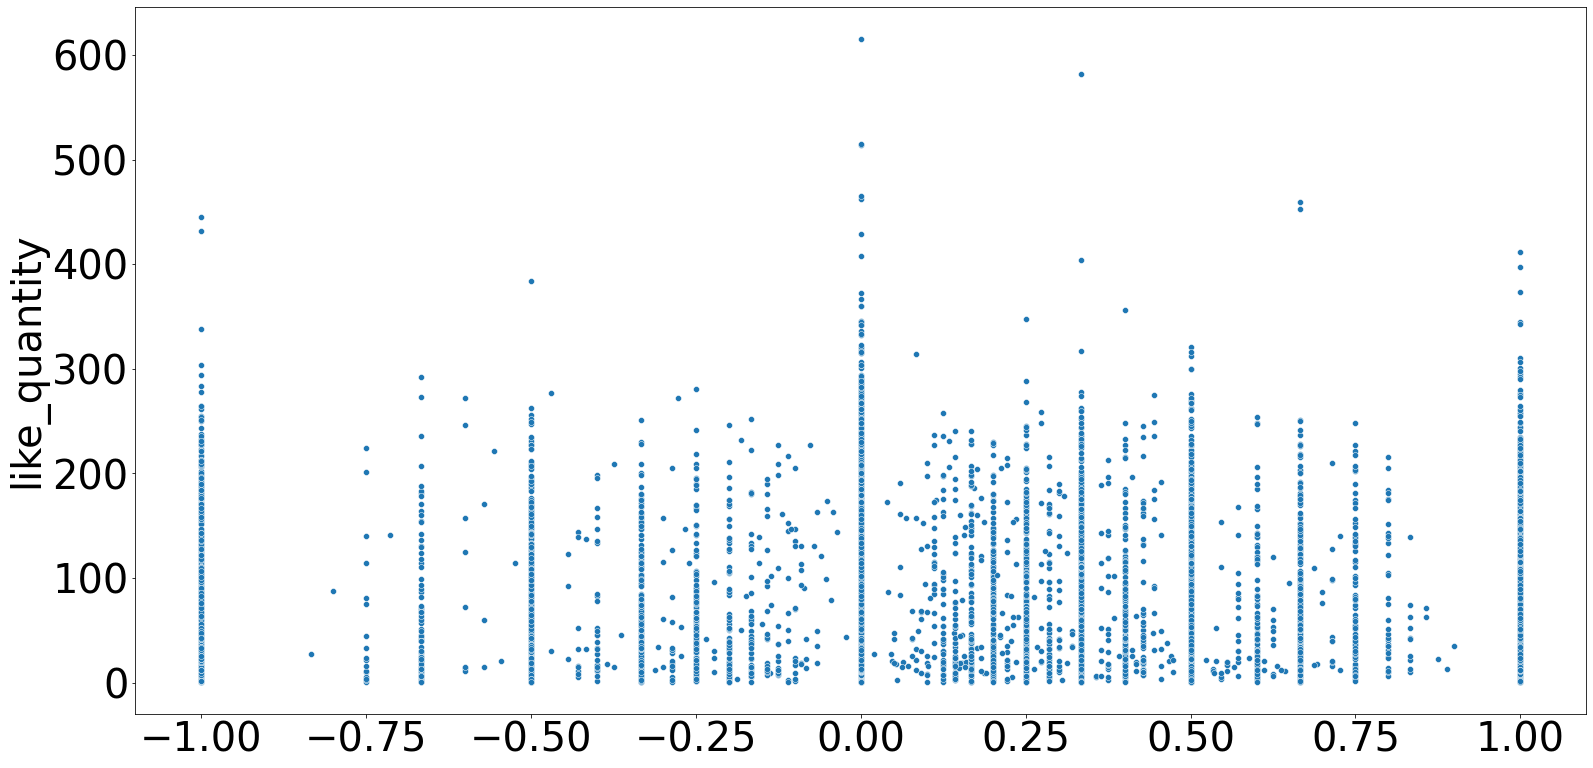

In [24]:


plt.figure(figsize=(26,13))
plt.rcParams["font.size"] = 40

iris = sns.load_dataset('iris')

sns.scatterplot(x='polar_new' , y='like_number', data=df_topic_nanacomi_new)
plt.xlabel("")
plt.ylabel('like_quantity')
plt.show()

In [25]:
df_likes_nanacomi_corr = df_topic_nanacomi_new[['polar_new', "like_number"]]
corranana = df_likes_nanacomi_corr .corr()
corranana

,polar_new,like_number
polar_new,1.000000,0.021518
like_number,0.021518,1.000000


In [26]:
df_topic_nanacomi_new["polar_abs"] = abs(df_topic_nanacomi_new['polar_new'])

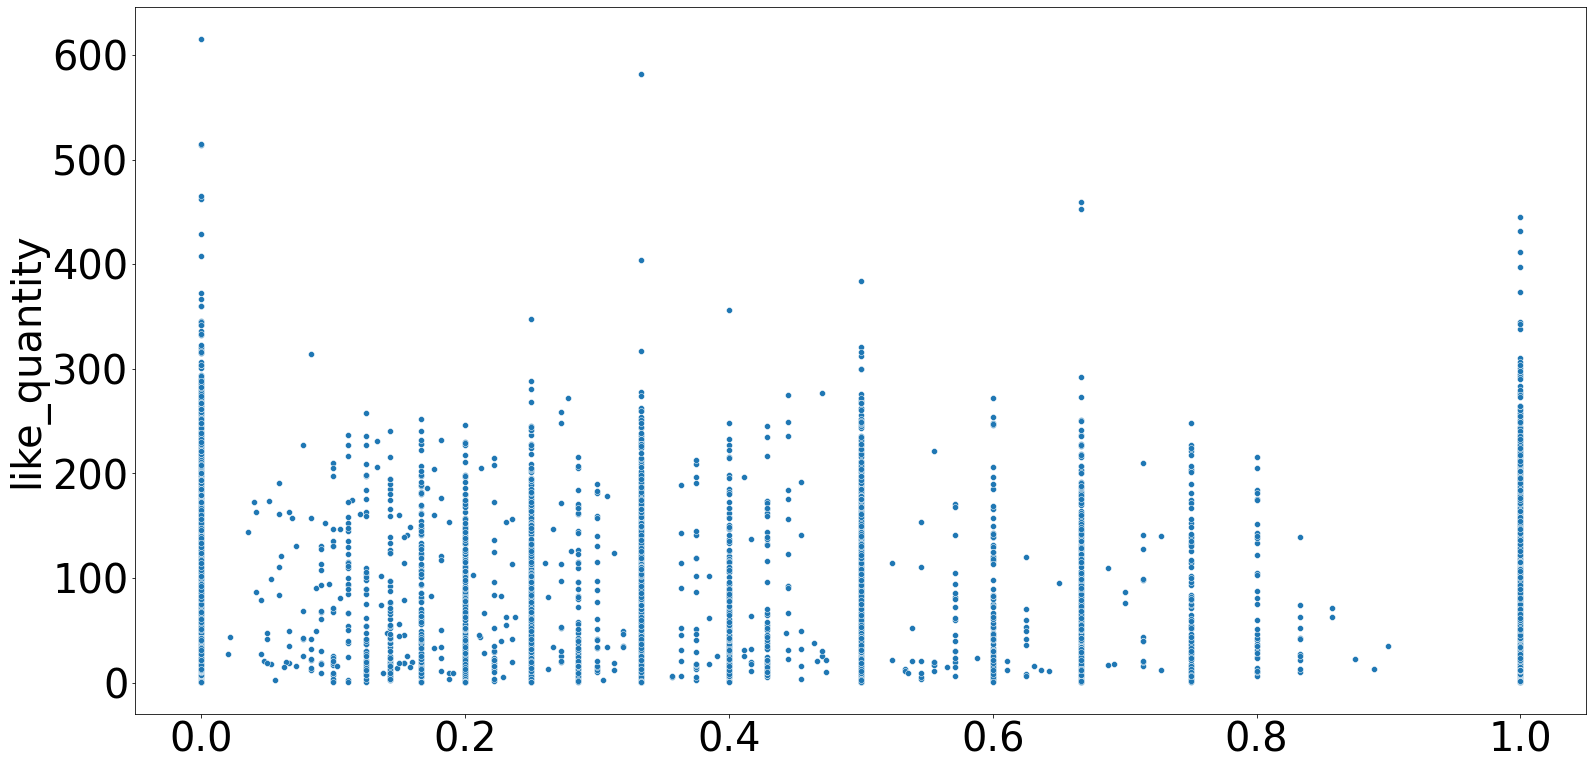

In [27]:


plt.figure(figsize=(26,13))
plt.rcParams["font.size"] = 40

iris = sns.load_dataset('iris')

sns.scatterplot(x='polar_abs' , y='like_number', data=df_topic_nanacomi_new)
plt.xlabel("")
plt.ylabel('like_quantity')
plt.show()

In [28]:
df_likes_nanacomi_corr = df_topic_nanacomi_new[['polar_abs', "like_number"]]
corranana = df_likes_nanacomi_corr .corr()
corranana

,polar_abs,like_number
polar_abs,1.000000,0.021871
like_number,0.021871,1.000000
